## kaggle : 
https://www.kaggle.com/c/dogs-vs-cats/data

In [7]:
import os, shutil
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras import models
from keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, Dropout
from keras.utils import to_categorical
from keras.datasets import mnist
from keras.utils import to_categorical

from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import numpy as np

In [10]:
small_dir = './datasets/cats_and_dogs_small'
train_dir = os.path.join(small_dir, 'train')
validation_dir = os.path.join(small_dir, 'validation')
test_dir = os.path.join(small_dir, 'test')

In [3]:

# 모든 이미지를 1/255로 스케일을 조정합니다
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator_img = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지를 150 × 150 크기로 바꿉니다
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하기 때문에 이진 레이블이 필요합니다
        class_mode='binary')

validation_generator_img = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
for data_batch, labels_batch in train_generator_img:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

배치 데이터 크기: (20, 150, 150, 3)
배치 레이블 크기: (20,)


In [8]:

from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## VGG16 feature 추출

In [11]:
#======================================= 장시간 주의 ==================================
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [12]:

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

## VGG16 feature 추출 후 -----> Full connect으로 학습

In [14]:
model = models.Sequential()
model.add(Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=10,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/10
100/100 [==============================] - 2s 19ms/step - loss: 0.5890 - acc: 0.6845 - val_loss: 0.4477 - val_acc: 0.8240
Epoch 2/10
100/100 [==============================] - 2s 19ms/step - loss: 0.4351 - acc: 0.8100 - val_loss: 0.3659 - val_acc: 0.8670
Epoch 3/10
100/100 [==============================] - 2s 19ms/step - loss: 0.3622 - acc: 0.8515 - val_loss: 0.3260 - val_acc: 0.8780
Epoch 4/10
100/100 [==============================] - 2s 18ms/step - loss: 0.3125 - acc: 0.8680 - val_loss: 0.2989 - val_acc: 0.8940
Epoch 5/10
100/100 [==============================] - 2s 19ms/step - loss: 0.2882 - acc: 0.8760 - val_loss: 0.2871 - val_acc: 0.8850
Epoch 6/10
100/100 [==============================] - 2s 18ms/step - loss: 0.2667 - acc: 0.8865 - val_loss: 0.2726 - val_acc: 0.8990
Epoch 7/10
100/100 [==============================] - 2s 19ms/step - loss: 0.2427 - acc: 0.9065 - val_loss: 0.2641 - val_acc: 0.9040
Epoch 8/10
100/100 [==============================] - 2s 19ms/step - 

In [15]:
model.save('03_3_cats_and_dogs_vgg_feature.h5')

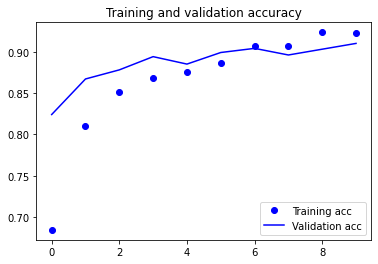

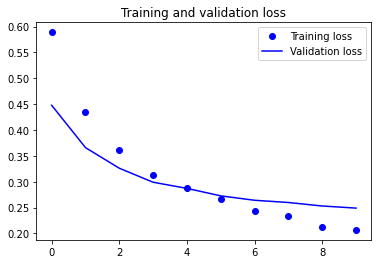

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()